### APRENDIZAJE PROFUNDO PARA PROCESAMIENTO DE INFORMACIÓN BIOMÉTRICA

# PRÁCTICA 1
### GRUPO 
* Hajar Boulehdid
* Sofía Santos Schmick
* Andrés Teruel Fernández

---


El primer paso es poner a punto el sistema para garantizar el correcto funcionamiento de la práctica. Para ello, es necesario crear un nuevo entorno con las siguientes versiones de librerías:
* Keras: 2.10.0
* Keras-Processing: 1.1.2
* TensorFlow: 2.10.1
* OpenCV: 4.10.0
* NumPy: 1.26.4

Una vez configurado el entorno con estas versiones, se procede a ejecutar el archivo face_recognition_main, en el cual se importan todas las librerías y funciones necesarias para el desarrollo de esta práctica.

In [1]:
import os
import numpy as np

# Remove most annoying tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from face_recognition_main import *

---

## CARGA DE LOS DATOS.

En esta pequeña sección utilizamos la función **load_datasets()** para la carga de dos conjuntos de datos que utilizaremos a lo largo de toda la práctica. Estos datasets estan formados por embeddigs de imágenes faciales procedentes de DiveFace.

Dichos datasets ya están preprocesados y guardados en dos archivos *pickle* para acelerar la ejecución del notebook.

In [2]:
embeddings_10_ppl_dataset, main_embeddings_dataset = load_datasets()

Embeddings dataset already exists. Loading...
Embeddings dataset already exists. Loading...
Embeddings datasets loaded.


---

## TAREA 1.0:

 - Revisa y entiende el código
 - Compara con la imagen 2 o 3 con las anterires.

In [3]:
def compare_images(img_path1, img_path2, threshold=0.5):
    """ Compara dos imágenes y devuelve si pertenecen a la misma persona """
    
    f1 = extract_features(img_path1, True)
    f2 = extract_features(img_path2, True)
    
    similarity = np.dot(f1, f2)
    
    if similarity >= threshold:
        print(f"Las imágenes pertenecen a la misma persona con similitud {similarity:.2f}")
        return True
    else:
        print(f"Las imágenes pertenecen a diferentes personas con similitud {similarity:.2f}")
        return False

In [4]:
"""Comparamos si son la misma persona a través de una simple.Detectamos las caras de las imagenes."""
images_dir = os.path.join('..', 'data', 'imagenes')
images = [os.path.join(images_dir, f"{i}.jpg") for i in range(4)]

for i in range(len(images)):
    for j in range(i + 1, len(images)):
        image1 = images[i]
        image2 = images[j]
        
        print(f"Image {i} vs image {j}: ", end='')
        compare_images(image1, image2)

Image 0 vs image 1: Las imágenes pertenecen a la misma persona con similitud 0.61
Image 0 vs image 2: Las imágenes pertenecen a diferentes personas con similitud 0.33
Image 0 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.36
Image 1 vs image 2: Las imágenes pertenecen a diferentes personas con similitud 0.38
Image 1 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.24
Image 2 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.21


En el directorio data/imagenes/ tenemos las siguientes imágenes con sus respectivas identidades:

* **0.jpg**: Albert Einstein
* **1.jpg**: Albert Einstein
* **2.jpg**: Nikola Tesla
* **3.jpg**: Stephen Hawking

Teniendo esto en cuenta podemos ver cómo, al comparar todas las imágenes con el resto, la extracción de características y el cálculo de similitudes parece funcionar correctamente dado que solo identifica a la misma persona en las imágenes 0.jpg y 1.jpg definiendo el umbral igual a 0.5. 

---

## TAREA 1.1: 

 - Generate a small database with a minimum of 3 images per person and 10 persons.
 - Develop a script to calculate the FAR and FRR curves.   

In [5]:
def calculate_far_frr(embeddings_db):
    """ Calcula FAR y FRR para diferentes umbrales y genera un gráfico. """
    thresholds=np.linspace(0, 1, 50)
    
    fars = []
    frrs = []
 
    people = list(embeddings_db.keys())

    for threshold in thresholds:
        false_accepts = 0
        false_rejects = 0
        total_genuine = 0
        total_impostor = 0

        for person in people:
            embeddings = embeddings_db[person]

            # Calcular FRR (False Rejection Rate)
            for i in range(len(embeddings)):
                for j in range(i + 1, len(embeddings)):
                    sim = np.dot(embeddings[i], embeddings[j].T)  # Comparar imágenes de la MISMA persona
                    total_genuine += 1
                    if sim < threshold:
                        false_rejects += 1  # Error: No reconoce a la persona correcta

            # Calcular FAR (False Acceptance Rate)
            for other_person in people:
                if other_person != person:
                    for emb1 in embeddings:
                        for emb2 in embeddings_db[other_person]:
                            sim = np.dot(emb1, emb2.T)  # Comparar imágenes de DIFERENTES personas
                            total_impostor += 1
                            if sim >= threshold:
                                false_accepts += 1  # Error: Acepta a la persona equivocada

        # Calcular tasas FAR y FRR
        far = false_accepts / total_impostor if total_impostor > 0 else 0
        frr = false_rejects / total_genuine if total_genuine > 0 else 0

        fars.append(far)
        frrs.append(frr)

    return fars, frrs, thresholds

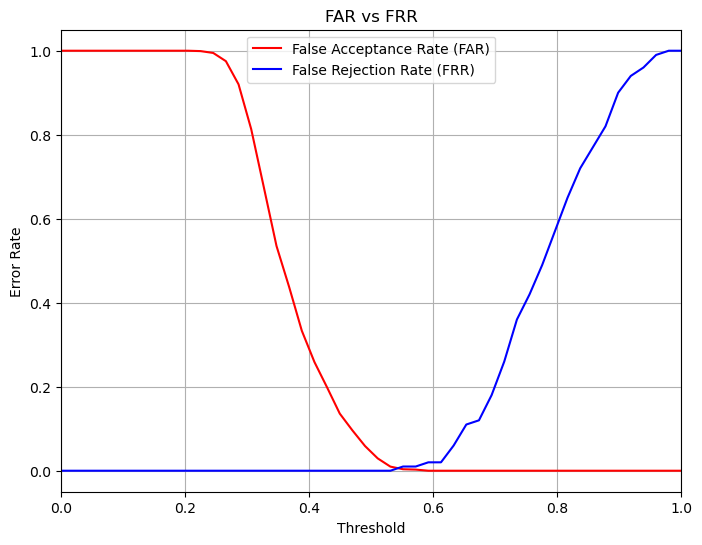

In [6]:
# Generar FAR, FRR y el gráfico
fars, frrs, thresholds = calculate_far_frr(embeddings_10_ppl_dataset)
plot_farr_frr(fars, frrs, thresholds)

Revisando las curvas FAR (proporción de falsos positivos) y FRR (proporción de falsos negativos), es interesante resaltar el reducido tamaño del área de intersección entre las áreas bajo ambas curvas, además del limitado intervalo en el que se encuentra (0.5, 0.6).

Es deseable en un modelo que dicha intersección sea lo más pequeña posible, ya que ello nos permite determinar un umbral óptimo que minimice ambas tasas. Además si el área es pequeña significa que, aunque sacrifiquemos alguna de las dos tasas en favor de la otra, el sacrificio no será demasiado grande. 

Con los resultados obtenidos parece que nos hayamos bajo un modelo áltamente competente a la hora de comparar e identificar a personas.

NOTA: Puesto que sólo hemos utilizado datos de 10 personas, no es una comparativa lo suficientemente extendida como para poder calificar el modelo, pero los resultados son muy notables.

In [7]:
def calcular_histograma_similitudes(embeddings_db, thresholds=np.linspace(0, 1, 50)):
    same_person=[]
    different_person=[]
    
    people = list(embeddings_db.keys())

    for person in people:
        embeddings = embeddings_db[person]

        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                sim = np.dot(embeddings[i], embeddings[j].T)  # Comparar imágenes de la MISMA persona
                same_person.append(sim)
    
            for other_person in people:
                if other_person != person:
                    for emb2 in embeddings_db[other_person]:
                        sim = np.dot(embeddings[i], emb2.T)  # Comparar imágenes de DIFERENTES personas
                        different_person.append(sim)


    return same_person, different_person


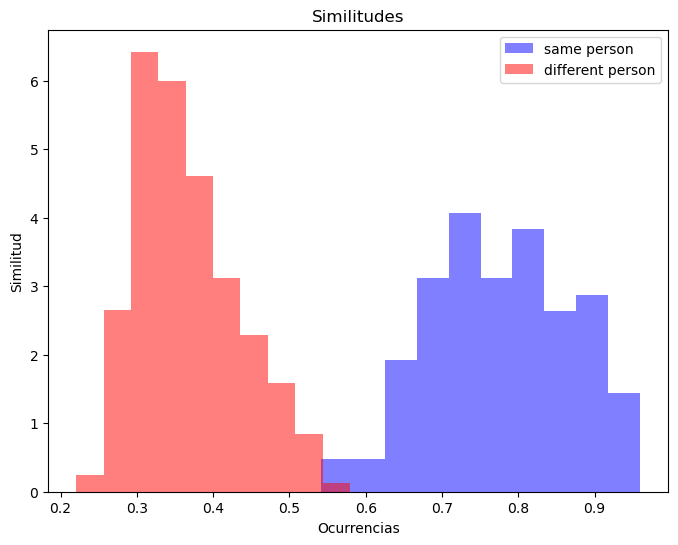

In [8]:
same_person, different_person = calcular_histograma_similitudes(embeddings_10_ppl_dataset)
plot_histogram(same_person, different_person)

Los histogramas de similitudes entre imágenes de la misma persona y de personas diferentes nos confirman el un intervalo para el umbral óptimo que podíamos intuir en las curvas FAR y FRR, dicho intervalo se encuentra entre el 0.53 y el 0.58. Hay un solapamiento entre las similitudes muy pequeño indicando, al igual que con las curvas FAR y FRR que si escogemos un umbral en el extremo del intervalo de solapamiento no obtendremos tasas muy grandes de falsa aceptación o de falso rechazo.

Los histogramas están normalizados para hacer una mejor comparación puesto que verdaderamente hay muchas más comparaciones de personas diferentes que de la misma persona, de forma que la curva roja quedaría mucho más grande que la azul.

De forma similar a las curvas FAR y FRR hay que ser escépticos con los resultados puesto que el estudio se ha realizado solo con las imágenes de 10 personas. Para hacer una valoración del modelo haría falta un estudio mucho más amplio.

---

## TAREA 1.2:

 - Read the DiveFace database and obtain the embeddings of 50 face images (1 image per subject) from the 6 demographic groups (50*6=300 embeddings in total).
 - DiveFace contains face images from 3 demographic groups (3 ethnicity and 2 gender)

In [9]:
# Llamar a la función para crear la base de datos de embeddings
embeddings_db_demographic = create_embeddings_subset(main_embeddings_dataset, 350)

# Verificar la cantidad de embeddings por grupo
for group_name, embeddings in embeddings_db_demographic.items():
    print(f"{group_name}: {len(embeddings)} embeddings")

MN4K_120: 350 embeddings
HN4K_120: 350 embeddings
MB4K_120: 350 embeddings
HB4K_120: 350 embeddings
HA4K_120: 350 embeddings
MA4K_120: 350 embeddings


Como observamos en la salida de la celda, hemos obtenido los embeddigs de 350 personas de los 6 grupos demográficos.

---

## TAREA 1.3:

 - Using t-SNE, represent the embeddings and its demographic group. Can you differentiate the different demographic groups?
 

In [10]:
def apply_tsne(embeddings_db):
    """Aplica t-SNE a los embeddings y los visualiza según su grupo étnico y género"""
    
    embeddings_list = []
    labels_list = []
    
    # Mapear grupos a valores numéricos
    group_mapping = {'HA': 0, 'HB': 1, 'HN': 2, 'MA': 3, 'MB': 4, 'MN': 5}  # 6 grupos según etnia y género
    
    # Guardar los embeddings mappeados con su etiqueta
    for group_name, embeddings in embeddings_db.items():
        ethnic_group = group_name[:2]  # Primeras dos letras indican grupo
        label = group_mapping[ethnic_group]  # Obtener la etiqueta del grupo
        
        for emb in embeddings:
            if isinstance(emb, np.ndarray) and emb.shape[0] > 0:  # Verifica si es un array válido
                embeddings_list.append(emb)
                labels_list.append(label)

    # Convertir la lista a una matriz numpy

    embeddings_matrix = np.vstack(embeddings_list)

     
    labels_array = np.array(labels_list)
 
    # Aplicar t-SNE
    tsne = TSNE(n_components=2, random_state=40)
    embeddings_2d = tsne.fit_transform(embeddings_matrix)
    
    return embeddings_2d, labels_array

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


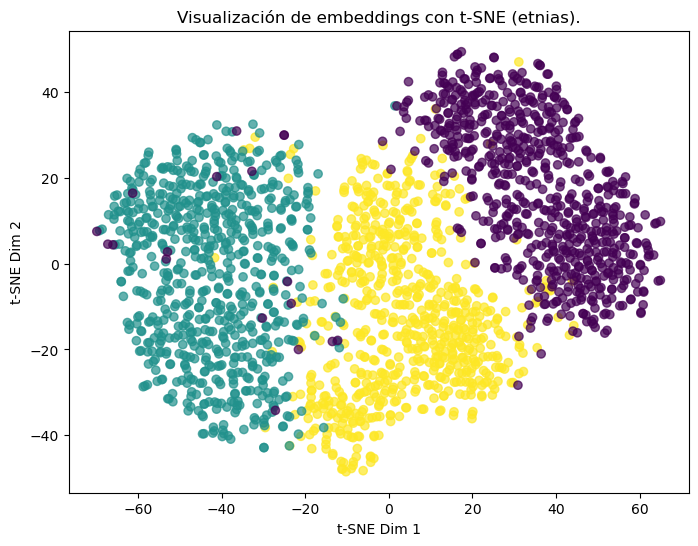

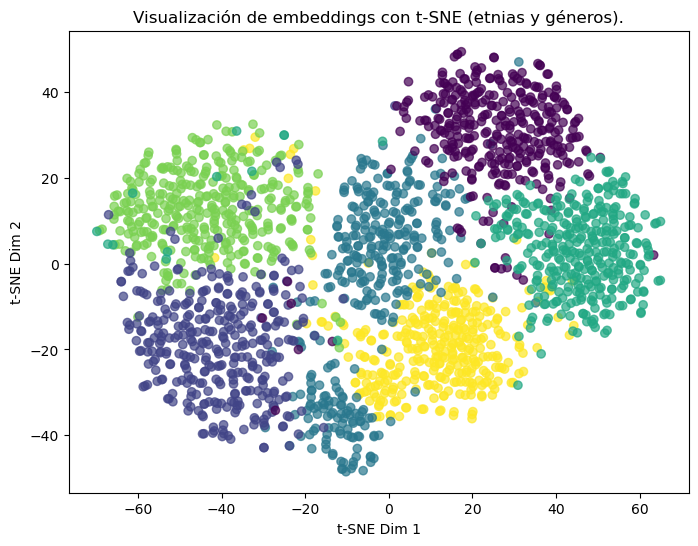

In [11]:
# Aplicar t-SNE a los embeddings
embeddings, labels_array = apply_tsne(embeddings_db_demographic)
plot_tsne(embeddings, labels_array)

Si transformamos los embeddings a una representación de 2 dimensiones mediantes TSNE se puede observar como naturalmente se separan en tres grupos muy bien diferenciados, correspondientes a las tres etnias separadas. Esto nos puede indicar como el modelo consigue diferenciar dichas características de forma intrínsica y codificarlas en los embeddings.

Incluso, viendo los resultados del segundo gráfico, dentro de cada grupo se pueden diferenciar dos subgrupos bastante separados indicando el sexo masculino y femenino de cada etnia.

Como hemos comentado en alguna lección, se aprecian algunas franjas significativas entre las diferentes etnias provenientes de un sesgo en la base de datos, puesto que individuos mestizos cuya clasificación es complicada han sido eliminados directamente de la base de datos. 

NOTA: Los resultados son susceptibles a la aleatoriedad de TSNE, pero en general son similares.

---

## TAREA 2.1:
 * Train 3 different Gender Classifiers (previous Task 1.4) using images from same ethnic group: Model A (only Asian), Model B (only Black), Model C (only Caucasian).

El entrenamiento de los 3 modelos se ha llevado a cabo haciendo uso de 1000 embbedings de cada grupo étnico (500 por cada género). De la misma manera que se ha hecho anteriormente, los embeddings se generan con el modelo `resnet50.h5`. 


En primer lugar, dividimos cada grupo de embeddings en un conjunto de train y otro de test haciendo uso de la función `generate_test_train`.

In [12]:
embeddings = divide_embeddings(main_embeddings_dataset)

for key, subset in embeddings.items():
    print(key)
    for key2, values in subset.items():
        if "x_" in key2:
            if "train" in key2:
                print(f"Training rows: {len(values)}")
            else: 
                print(f"Testing rows: {len(values)}")

A
Training rows: 1005
Testing rows: 495
B
Training rows: 1005
Testing rows: 495
N
Training rows: 1005
Testing rows: 495


En segundo lugar , creamos un modelo Clasificador de Género basado en embeddings que se define con la arquitectura de una red neuronal artificial simple. Este está compuesta por :
1. **Capa de entrada**. La red recibe un vector de 2048 dimensiones, que corresponde al embedding extraído previamente de la ResNet-50 preentrenada.
2. **Capa oculta**. Tiene 2048 neuronas y usa la función de activación ReLU.
3. **Capa de salida**. Es una capa de clasificación binaria con 2 neuronas, una para cada clase de género. Usa la activación softmax.

En cuanto a la compilacióm, se emplea el optimizador Adam y la función de pérdidas categorical_crossentropy.


A continuación , entrenamos un modelo para cada uno de los grupos étnicos: Asiáticos (Modelo A), Blancos (Modelo B), Negros (Modelo B).

In [13]:
gender_models = {'A': None, 'B': None, 'N': None}

for ethnicity in gender_models.keys():
    gender_models[ethnicity], accuracy, val_accuracy = train_gender_model(
        embeddings[ethnicity]["x_train"], 
        embeddings[ethnicity]["y_train"], 
        embeddings[ethnicity]["x_test"], 
        embeddings[ethnicity]["y_test"]) 
    
    print(f"Model {ethnicity} trained.")

Model A trained.
Model B trained.
Model N trained.


---

## TAREA 2.2:
 * Evaluate the 3 Gender Classifiers (previous Task 2.1) using images from each of the three ethnic groups.
 * Evaluation: **3 test sets** x **3 models** = **9 accuracies**

La evaluación de los tres modelos se realizará utilizando tanto imágenes del grupo étnico con el que fueron entrenados como imágenes de los demás grupos étnicos. Como métrica se empleará la accuracy.

In [14]:
get_all_accuracies_table(gender_models, embeddings)

,Model A,Model B,Model N
Dataset A,99.6667,86.8667,82.8000
Dataset B,86.8667,99.4000,80.0000
Dataset N,97.6667,90.4000,99.4000


En la tabla anterior se muestran los resultados obtenidos. Los resultados indican que cada modelo tiene un desempeño excelente cuando se evalúa con imágenes del mismo grupo étnico con el que fue entrenado (valores cercanos al 100%). Sin embargo, el rendimiento disminuye cuando los modelos se prueban con imágenes de otros grupos étnicos. 

* **Modelo A**. Explicar
* **Modelo B**. Explicar
* **Modelo N**. Explicar


Por lo tanto, los modelos podrían estar sobreajustándose a las características específicas de cada grupo étnico, lo que reduciría su capacidad de generalización a otras etnias. Esto pone en evidencia el sesgo empleado en los datos de entrenamiento .
¿Qué modelo generaliza mejor teniendo en cuenta el sesgo?

In [15]:

def predict_gender(model_key, img_path):
    """
    Realiza la predicción de género a partir de una imagen usando el modelo especificado.
    
    Parámetros:
    - model_key (str): Clave del modelo a usar ('A', 'B' o 'N').
    - img_path (str): Ruta de la imagen a evaluar.
    
    Imprime la imagen, la predicción y la clase predicha.
    """
    if model_key not in gender_models:
        print("Error: Modelo no válido. Usa 'A', 'B' o 'N'.")
        return
    
    model = gender_models[model_key]

    # Cargar y mostrar la imagen original
    img = cv2.imread(img_path)
    if img is None:
        print("Error: No se pudo cargar la imagen.")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(2, 2)) 
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Imagen de entrada ({model_key})")
    plt.show()

    # Extraer la cara de la imagen
    img_face = extract_faces(img_path)

    if img_face is None:
        print("No se detectó ninguna cara en la imagen.")
        return

    # Generar embedding de la cara detectada
    embedding = generate_embedding(img_face)

    if embedding is not None:
        embedding = np.asarray(embedding).reshape(1, -1)  # Asegurar la forma correcta (1, 2048)

        # Usar el modelo correspondiente para la predicción
        prediction = model.predict(embedding)
        predicted_class = np.argmax(prediction, axis=1)

        print("Predicción:", prediction)
        print("Clase predicha:", "Hombre" if predicted_class[0] == 0 else "Mujer")
    else:
        print("No se pudo generar el embedding de la imagen.")



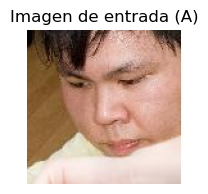

1/1 [==============================] - 0s 25ms/step
Predicción: [[9.999528e-01 4.719561e-05]]
Clase predicha: Hombre


In [16]:
img_path = '../data/imagenes/12494527693_0.jpg'
predict_gender('A', '../data/imagenes/2312469191_3.jpg')

In [17]:
predict_gender('A', '../data/imagenes/12494527693_0.jpg')

Error: No se pudo cargar la imagen.


[ WARN:0@31.935] global loadsave.cpp:268 findDecoder imread_('../data/imagenes/12494527693_0.jpg'): can't open/read file: check file path/integrity


---

## TAREA 2.3:
 * Train one Gender Classifiers (previous Task 1.4) using images from all three ethnic groups.

De la misma manera que en el apartado anterior, vamos a a entrenar un modelo Clasificar de Género pero esta vez empleando 1000 embeddings de cada uno de los 3 grupos étnicos.


Primero, dividimos cada grupo de embeddings en un conjunto de train y otro de test haciendo uso de la función `generate_test_train`. Y acontinuación, entrenamos el modelo. 

In [18]:
x_train, x_test, y_train, y_test = generate_test_train(main_embeddings_dataset)

In [19]:
generic_model, accuracy, val_accuracy = train_gender_model(x_train, y_train, x_test, y_test) 
print(f"Generic model trained.")

Generic model trained.


---

## TAREA 2.4:
 * Evaluate the Gender Classifier (previous Task 2.3) using images from each of the three ethnic groups.
 * Evaluation: **3 test sets** x **1 models** = **3 accuracies**

In [20]:
get_all_accuracies_table({'generic': generic_model}, embeddings)

,Model generic
Dataset A,99.8000
Dataset B,99.6667
Dataset N,99.6667


hcaer un entrenamiento mixo, hacer un 80% una etnia y 20% otra, varias combinaciones

ROC CURVE
y_score: las distancias
y_true: etiquetas 


---

## TAREA 2.5 EXTRA (ES LA TAREA EXTRA ORIGINAL, TAL VEZ NO QUEREMOS USARLO Y QUEREMOS HACER LO QUE DIJO EL PROFE):
Entrenar por etnia para cada género. Cresr dos modelos, uno  para hombres y otro para mujeres 



In [21]:
def get_X_y_etnias(embeddings_db):
    """
    Convierte un diccionario de embeddings en matrices X e y.
    Parámetros:
    - embeddings_db: dict, diccionario con claves que indican el grupo y valores con listas de embeddings.
 
    Retorna:
    - X: numpy array con los embeddings.
    - y: numpy array con las etiquetas de género (one-hot encoded).
    """
    X = []
    y = []
 
    for label, embeddings in embeddings_db.items():
        if label[1] == 'A': 
            etnia = 0 # asiatico
        elif label[1] == 'B':
            etnia = 1 # blanco
        else:
            etnia = 2 # negro
        for emb in embeddings:
            X.append(emb)
            y.append(etnia)
 
    X = np.array(X).astype(float)
    y = to_categorical(y)  # Convertir a one-hot encoding

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
 
    return X_train, X_test, y_train, y_test


def gender_model_etnias():
    model = Sequential([
        Dense(60, input_dim=2048, activation='relu'),
        Dense(3, activation='softmax')  # 3 clases: 3 etnias
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def entrenamiento_etnias(X_train, y_train, epocas=10, n_splits=10):
    # Crear el clasificador Keras
    estimator = KerasClassifier(build_fn=gender_model_etnias, epochs=epocas, batch_size=5, verbose=0)
    # Validación cruzada con 10 folds
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results= cross_val_score(estimator, X_train, y_train, cv=kfold, verbose=0)
    return estimator, results

In [22]:
grupos_filtrados = ['HA4K_120', 'HB4K_120', 'HN4K_120']
embeddings_db_H = {k: v for k, v in embeddings_db_demographic_500.items() if k in grupos_filtrados}
X_train_H, X_test_H, y_train_H, y_test_H = get_X_y_etnias(embeddings_db_H)

estimator_H, results_H = entrenamiento_etnias(X_train_H, y_train_H, epocas, n_splits=5)
print("Accuracy del modelo de etnia, genero hombre: %.2f%% (%.2f%%)" % (results_H.mean()*100, results_A.std()*100))

NameError: name 'embeddings_db_demographic_500' is not defined

In [ ]:
grupos_filtrados = ['MA4K_120', 'MB4K_120', 'MN4K_120']
embeddings_db_M = {k: v for k, v in embeddings_db_demographic_500.items() if k in grupos_filtrados}
X_train_M, X_test_M, y_train_M, y_test_M = get_X_y_etnias(embeddings_db_M)

estimator_M, results_M = entrenamiento_etnias(X_train_M, y_train_M, epocas, n_splits=5)
print("Accuracy del modelo de etnia, genero mujer: %.2f%% (%.2f%%)" % (results_M.mean()*100, results_A.std()*100))

In [ ]:
# TEST
# Entrenar modelo en el conjunto de entrenamiento completo
estimator_H.fit(X_train_H, y_train_H)
 
test_accuracy_HH = estimator_H.score(X_test_H, y_test_H)
print("Accuracy en test: %.2f%%" % (test_accuracy_AA * 100))

test_accuracy_HM = estimator_H.score(X_test_M, y_test_M)
print("Accuracy en test: %.2f%%" % (test_accuracy_AB * 100))

In [ ]:
estimator_M.fit(X_train_M, y_train_M)

test_accuracy_MM = estimator_M.score(X_test_M, y_test_M)
print("Accuracy en test: %.2f%%" % (test_accuracy_BB * 100))

test_accuracy_MH = estimator_M.score(X_test_H, y_test_H)
print("Accuracy en test: %.2f%%" % (test_accuracy_BA * 100))


In [ ]:
# tabla de 3x3 con las acuracies
valores_etnias = [
    [test_accuracy_HH, test_accuracy_HM],  # Fila Modelo H
    [test_accuracy_MH, test_accuracy_MM]   # Fila Modelo M
]


df = pd.DataFrame(valores_etnias, index=["Modelo H", "Modelo M"], columns=["Train H", "Train M"])


df_styled = df.style.background_gradient(cmap='Blues', low=0.1, high=0.2).set_caption("Tabla de Accuracies").format("{:.4f}").set_table_styles([{
                        'selector': 'table', 
                        'props': [('font-size', '20px'), ('width', '100%')]
                    }, {
                        'selector': 'th', 
                        'props': [('font-size', '20px'), ('text-align', 'center')]
                    }, {
                        'selector': 'td', 
                        'props': [('font-size', '16px'), ('text-align', 'center')]
                    }])
                    

df_styled